In [280]:
import torch 
from torch import nn 
import torchvision 
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

In [281]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset

In [282]:
data_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
])

caltech_data = datasets.ImageFolder(
    root='Data/caltech256/256_ObjectCategories/',
    transform=data_transform
)

print(
    len(caltech_data), 
    type(caltech_data), 
    len(caltech_data.classes), 
    sep='\n'
)

30608
<class 'torchvision.datasets.folder.ImageFolder'>
257


In [283]:
NUM_CLASSES = len(caltech_data.classes)

In [284]:
def custom_train_test_split(dataset, test_split=0.30):
    train_idx, test_idx = train_test_split(
        list(range(len(dataset))), 
        test_size=test_split
    )
    
    datasets = {}
    datasets['train'] = torch.utils.data.Subset(dataset, train_idx)
    datasets['test'] = torch.utils.data.Subset(dataset, test_idx)
    
    return datasets

caltech_data = custom_train_test_split(caltech_data)

In [285]:
train_dataloader = torch.utils.data.DataLoader(
    caltech_data['train'],
    batch_size=32,
    shuffle=True,
    drop_last=True
)
test_dataloader = torch.utils.data.DataLoader(
    caltech_data['test'],
    batch_size=32
)

print(f"Length of Train DataLoader: {len(train_dataloader)}, \
Batch Size: {train_dataloader.batch_size}")
print(f"Length of Test DataLoader: {len(test_dataloader)}, \
Batch Size: {test_dataloader.batch_size}")

Length of Train DataLoader: 669, Batch Size: 32
Length of Test DataLoader: 287, Batch Size: 32


In [286]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

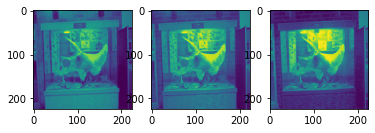

In [287]:
# visualize data 

# torch.manual_seed(42)

random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
cnt = 1

for index in range(3):
    plt.subplot(1, 3, cnt)
    cnt += 1
    plt.imshow(img[index])
    
plt.show()

# Build Model

In [288]:
class ImageClassifierModel(nn.Module):
    def __init__(
        self, 
        input_shape: int,
        output_shape: int
    ):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_stack(x)

In [289]:
torch.manual_seed(42)

model = ImageClassifierModel(
    input_shape = 3*224*224,
    output_shape = NUM_CLASSES
).to(device)

print(model)

ImageClassifierModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=150528, out_features=1024, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=257, bias=True)
  )
)


In [290]:
# check with random value

dummy_x = torch.rand([32, 3, 224, 224])
torch.argmax(nn.functional.softmax(model(dummy_x), dim=1), dim=1)

tensor([236, 236, 236, 236, 236, 119, 160, 160, 160, 217, 160,  20, 236, 160,
        236, 236, 236, 160, 217, 217, 160, 236, 236, 236, 217, 160, 160, 236,
        236, 236, 217, 217])

# Train

In [291]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params = model.parameters(),
    lr = 0.1
)

In [292]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    
    return acc

In [293]:
# training loop 

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}")
    train_loss = 0
    
    for batch, (image, target) in enumerate(train_dataloader):
        model.train()
        y_pred_logits = model(image)
        
        #train loss calculate
        tl = loss_fn(y_pred_logits, target)
        train_loss += tl
        
        #optimizer zero grad --> backpropagation --> step
        optimizer.zero_grad()
        tl.backward()
        optimizer.step()
        
        if batch % 500 == 0:
            print(f"Looked at {batch * len(image)}/{len(train_dataloader.dataset)} samples")
    
    train_loss /= len(train_dataloader)    
    test_loss, test_acc = 0, 0
    
    model.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            test_pred = model(X_test)
            test_loss += loss_fn(test_pred, y_test)
            test_acc += accuracy_fn(
                y_true = y_test,
                y_pred = test_pred.argmax(dim=1)
            )
            
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        
    
    print(
        f"\nTrain Loss: {train_loss:.4f} Test Loss: {test_loss:.4f}, \
        Test Acc: {test_acc}\n"
    )        

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Looked at 0/21425 samples
Looked at 16000/21425 samples

Train Loss: 57861.6016 Test Loss: 5.4659,         Test Acc: 2.864027200179836

Epoch: 1
Looked at 0/21425 samples
Looked at 16000/21425 samples

Train Loss: 5.4844 Test Loss: 5.4723,         Test Acc: 2.5700376531415086

Epoch: 2
Looked at 0/21425 samples
Looked at 16000/21425 samples

Train Loss: 5.4885 Test Loss: 5.4829,         Test Acc: 2.8636759581881535

